# Gather metadata for software

## Import libraries

In [1]:
import json
import requests
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect metadata for 5,000 software records
Originally I tried collecting all 5,000 at once, but they are from 2020-2022 and there are a ton of records from aacr.figshare that are figures and tables mislabelled as software. So do it by year. But you can't limit to published before, only published since. Need to use order by to get older dates.

## Set variables

In [2]:
BASE_URL = "https://api.figshare.com/v2"

In [85]:
#Gather basic metadata for items (articles) that meet your search criteria
results = []

#Get newer records
query = '{"item_type": 9}' #Search for software
y = json.loads(query) #Figshare API requires json paramaters
for j in range(1,4): #Collect 3,000 records 
    records = json.loads(requests.post(BASE_URL + '/articles/search?page_size=1000&page={}'.format(j), params=y).content)
    results.extend(records)
    
#Get older records
query = '{"item_type": 9, "order": "published_date", "order_direction": "asc", "published_since": "2013-01-01"}' #Search for software 
y = json.loads(query) #Figshare API requires json paramaters
for j in range(1,4): #Collect 3,000 records
    records = json.loads(requests.post(BASE_URL + '/articles/search?page_size=1000&page={}'.format(j), params=y).content)
    results.extend(records)
    
#See the number of articles
print(len(results),'articles retrieved')

6000 articles retrieved


## Clean the records

In [87]:
#Remove any duplicates
dforiginal = pd.DataFrame(results)
df_basic = dforiginal.drop_duplicates(subset=['id'])
print(len(dforiginal)-len(df_basic),'records removed')

0 records removed


In [7]:
#Remove the aacr.figshare records
tempdf = df_basic[['id','url_public_html']]
item_ids_to_remove = tempdf[tempdf['url_public_html'].str.contains("aacr.figs")]
item_ids_to_remove_list = item_ids_to_remove['id'].tolist()
print(len(item_ids_to_remove_list), 'to remove')

1026 to remove


In [20]:
#Save the removed ids. This saves the series (rather than the list)
save_file = item_ids_to_remove['id'].to_csv('removed.csv',encoding='utf-8', index=None)

In [93]:
df_basic_cleaned = df_basic[~df_basic['id'].isin(item_ids_to_remove_list)]
print(len(df_basic)-len(df_basic_cleaned),'items deleted')

-1026 items deleted


In [18]:
#Remove those records from the json
software_basic = []

for element in results:
    if element['id'] not in item_ids_to_remove_list: #If he item id is not in the list of things to remove
        software_basic.append(element)    
print(len(results)-len(software_basic),'records removed')

1026 records removed


In [95]:
#Save the uncleaned json.
with open('software-uncleaned-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(results, f)

In [22]:
#Save the cleaned json.
with open('software-cleaned-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(software_basic, f)

In [97]:
#Save a file of all the metadata
save_file = df_basic_cleaned.to_csv('software-basic-cleaned'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

## Check the records for dates

In [23]:
#The dates are all contained within one column called 'timeline'. Flatten that column and associate the values
#with the proper article id in a new dataframe

temp_date_list = []

for item in software_basic:
    dateitem = item['timeline']
    dateitem['id'] = item['id']
    temp_date_list.append(dateitem)

df_dates = pd.json_normalize(
    temp_date_list 
)

df_dates.replace(df_dates.replace(r'^\s*$', 'null', regex=True, inplace = True)) #Replace blank cells with 'null'

#Merge the dataframes
dfbasic = df.merge(df_dates, how='outer', on='id')

print("Dates split out and merged")

Dates split out and merged


<ipython-input-25-35b174f69ea6>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize = 12)


[Text(0, 0.0, '0.0'),
 Text(0, 200.0, '200.0'),
 Text(0, 400.0, '400.0'),
 Text(0, 600.0, '600.0'),
 Text(0, 800.0, '800.0'),
 Text(0, 1000.0, '1000.0'),
 Text(0, 1200.0, '1200.0')]

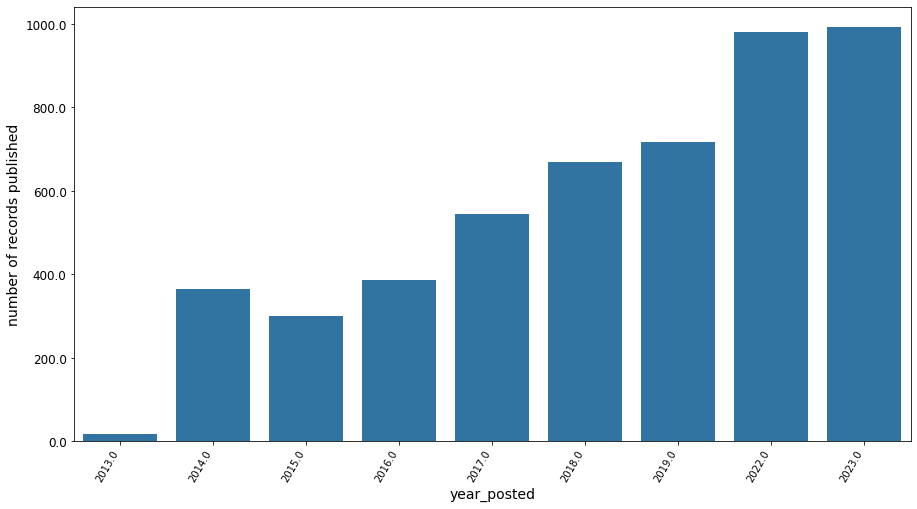

In [25]:
#Use the posted date because the firstOnline date may not align with the actual Figshare record. 
#The posted date as this is the date posted on Figshare.

#Add year and month posted columns
dfbasic['year_posted'] = pd.DatetimeIndex(dfbasic['posted']).year
dfbasic['month_posted'] = pd.DatetimeIndex(dfbasic['posted']).month

#Another way to do it...Split the year out and add it as a column
#year = df_full["firstOnline"].str.split("-", n = 1, expand = True)
#df_full['year'] = year[0]

#Group by year
datechart = dfbasic.groupby(['year_posted']).count().reset_index()

#Chart it all out
#sns.color_palette("husl", 8)
plt.rcParams["figure.figsize"] = (15,8)
ax = sns.barplot(data=datechart, x="year_posted", y="id", palette=["C0"])
#ax.set(xlabel='year', ylabel='number of records published')
ax.set_ylabel("number of records published", fontsize = 14)
ax.set_xlabel("year_posted", fontsize = 14)
ax.set_xticklabels(datechart['year_posted'], fontsize = 10, rotation=60, ha="right")
ax.set_yticklabels(ax.get_yticks(), fontsize = 12)

There are just over 10,000 software items from 2013 to now based on a figshare.com search. So this dataset seems to represent that pretty well. Missing 2021 and 2022 posted items (3,162 items). There are 955 items from 2019 so not complete there. But can still use this for a high level comparison across time.

In [9]:
#Create a dataframe from the JSON formatted data
#dfbasic = pd.DataFrame(results)

In [19]:
#Open a file if needed
#dfbasic = pd.read_csv('software-2023-05-13.csv',encoding='utf8')

In [26]:
#Create a list of all the article ids
article_ids = dfbasic['id'].tolist()

In [27]:
#article_ids2 = article_ids[12679:16047]
len(article_ids)

4974

In [28]:
item_metadata = []
author_metadata = []
funding_metadata = []
categories_metadata = []
tags_data = []
files_metadata = []
error_count = 0

for item in article_ids:
    m = requests.get(BASE_URL + '/articles/' + str(item))
    metadata=json.loads(m.text)
    
    if m.status_code == 200: #if the record is retrievable

        views = json.loads(requests.get('https://stats.figshare.com/total/views/article/' + str(item)).content)
        #Add views to the full metadata record and add to the main list
        metadata['views'] = views['totals']
        item_metadata.append(metadata)

        #Add item id to each set of content for individual tables
        authors = metadata['authors']
        for a in authors:
            a['item_id'] = item
            author_metadata.append(a)

        funding = metadata['funding_list']
        for f in funding:
            f['item_id'] = item
            funding_metadata.append(f)
    
        cats = metadata['categories']
        for c in cats:
            c['item_id'] = item
            categories_metadata.append(c)
    
        for t in metadata['tags']: #tags are a list so its a bit different
            tags = {}
            tags['item_id'] = item
            tags['name'] = t
            tags_data.append(tags)

        if metadata['is_embargoed'] == 0: #If the record is not embargoed
            if len(metadata['files']) > 0: #If the record is not 'metadata only'
                files = metadata['files']
                for f in files:
                    f['item_id'] = item
                    files_metadata.append(f)
    else:
        error_count += 1
    
    
print('Full metadata for',len(item_metadata),'items retrieved.', error_count,'items had an error')


Full metadata for 4972 items retrieved. 2 items had an error


In [29]:
#save the json. 
with open('full_records-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(item_metadata, f)

with open('author-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(author_metadata, f)

with open('funding-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(funding_metadata, f)

with open('categories-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(categories_metadata, f)

with open('tags-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(tags_data, f)

with open('files-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(files_metadata, f)

In [50]:
#Create a dataframe from the JSON formatted data
df_metadata = pd.DataFrame(item_metadata)
print('Done!')

Done!


In [9]:
#If you need to open json files

with open("author-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    author_metadata = json.load(read_file)

with open("funding-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    funding_metadata = json.load(read_file)

with open("categories-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    categories_metadata = json.load(read_file)
    
with open("tags-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    tags_data = json.load(read_file)
    
#For some reason files json never got saved.


## Format the data

### Split out the dates

In [51]:
#The dates are all contained within one column called 'timeline'. Flatten that column and associate the values
#with the proper article id in a new dataframe

temp_date_list = []

for item in item_metadata:
    dateitem = item['timeline']
    dateitem['id'] = item['id']
    temp_date_list.append(dateitem)

df_dates = pd.json_normalize(
    temp_date_list 
)

df_dates.replace(df_dates.replace(r'^\s*$', None, regex=True, inplace = True)) #Replace blank cells with None (used to do 'null' but that didnt work)
#Merge the dataframes
df = df_metadata.merge(df_dates, how='outer', on='id')

print("Dates split out and merged")

Dates split out and merged


### Remove columns in main set that are separate tables

In [52]:
df = df.drop(columns=['files', 'authors','funding','funding_list','tags','categories','timeline'])

### If group_id is not null, then assign the record a institutional/publisher tag. Otherwise, figshare.com

In [54]:
df['origin'] = 'figshare-user' #create a new column and fill with default values
df['edited_group_id'] = df['group_id']
df['edited_group_id'].replace(np.nan, 999999999999, inplace=True)
df.loc[df['edited_group_id'] != 999999999999, 'origin'] = 'organization'

### Replace blanks with 'null' and rename id column

In [ ]:
df.replace(df.replace(r'^\s*$', np.nan, regex=True, inplace = True)) #Replace blank cells with 'null'
#df.fillna(value='null', inplace=True) #Note- why do this??? why not leave as nan?
df = df.rename(columns={'id': 'item_id'}) #Rename id col in main dataframe

## Create all other dataframes

In [35]:
authorsdf = pd.json_normalize(author_metadata)
authorsdf.replace(authorsdf.replace(r'^\s*$', 'null', regex=True, inplace = True)) #Replace blank cells with 'null'

fundersdf = pd.json_normalize(funding_metadata)
fundersdf.replace(fundersdf.replace(r'^\s*$', 'null', regex=True, inplace = True)) #Replace blank cells with 'null'

categoriesdf = pd.json_normalize(categories_metadata)

tagsdf = pd.DataFrame(tags_data, columns=["item_id","name"], index=None)

filesdf = pd.json_normalize(files_metadata)

### Save to one excel book and/or separate csvs

In [59]:
#Some of the contents has unicode which excel won't accept. Need to replace (https://stackoverflow.com/questions/28837057/pandas-writing-an-excel-file-containing-unicode-illegalcharactererror)
df = df.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)

fundersdf = fundersdf.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)

with pd.ExcelWriter("metadata.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df.to_excel(writer, sheet_name="main", index=False)
    authorsdf.to_excel(writer, sheet_name="authors", index=False)
    fundersdf.to_excel(writer, sheet_name="funding", index=False)
    categoriesdf.to_excel(writer, sheet_name="categories", index=False)
    tagsdf.to_excel(writer, sheet_name="tags", index=False)
    filesdf.to_excel(writer, sheet_name="files", index=False)

In [37]:
#Save to separate CSVs if you want
save_file = authorsdf.to_csv('authors.csv',encoding='utf-8', index=None)

save_file = fundersdf.to_csv('funding.csv',encoding='utf-8', index=None)

save_file = categoriesdf.to_csv('categories.csv',encoding='utf-8', index=None)

save_file = tagsdf.to_csv('tags.csv',encoding='utf-8', index=None)

save_file = filesdf.to_csv('files.csv',encoding='utf-8', index=None)

save_file = df.to_csv('main.csv',encoding='utf-8', index=None)

# Analysis

In [2]:
#Open a file if needed
df = pd.read_csv('main.csv',encoding='utf8')
authorsdf = pd.read_csv('authors.csv',encoding='utf8')
fundersdf = pd.read_csv('funding.csv',encoding='utf8')
categoriesdf = pd.read_csv('categories.csv',encoding='utf8')
tagsdf = pd.read_csv('tags.csv',encoding='utf8')
filesdf = pd.read_csv('files.csv',encoding='utf8')

### Set parameters for charts

In [3]:
#parameters
chart_title_font = 25
y_axis_label_font = 15
x_tick_size = 20
y_tick_size = 20
startfont = 30

#set color properties for box plots https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

colors = ["#D9D9D9","#5A5A5A"] #"#FFFFFF"

### What domains are present?

In [43]:
from collections import Counter

In [36]:
#Open json if needed
with open("software-cleaned-2023-06-02.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    software_basic = json.load(read_file)

In [44]:
#Look at the institutions represented
url = []
for s in software_basic:
    url.append(s['url_public_html'][8:22])

unique_domains = Counter(url)
unique_domains

Counter({'figshare.com/a': 4215,
         'opticapublishi': 108,
         'royalholloway.': 6,
         'auckland.figsh': 23,
         'su.figshare.co': 2,
         'plos.figshare.': 22,
         'figshare.shef.': 55,
         'bridges.monash': 42,
         'melbourne.figs': 19,
         'uvaauas.figsha': 13,
         'caryinstitute.': 2,
         'zivahub.uct.ac': 12,
         'figshare.manch': 10,
         'kilthub.cmu.ed': 3,
         'springernature': 109,
         'data.ncl.ac.uk': 17,
         'jstagedata.jst': 2,
         'rdr.ucl.ac.uk/': 11,
         'data.dtu.dk/ar': 12,
         'rs.figshare.co': 33,
         'smithsonian.fi': 5,
         'researchdata.u': 3,
         'cord.cranfield': 16,
         'datahub.hku.hk': 5,
         'rmit.figshare.': 3,
         'iastate.figsha': 1,
         'figshare.scili': 3,
         'kcl.figshare.c': 5,
         'arizona.figsha': 3,
         'data.4tu.nl/ar': 57,
         'repository.lbo': 20,
         'dayta.nwu.ac.z': 2,
         'datarepo

In [47]:
origindf = df.groupby(by=['origin']).count().reset_index()

In [48]:
origindf

#So there is one record that may or may not be figshare.com, but this aligns well with the domains

origin  custom_fields  figshare_url  description  version  status  \
0  figshare-user           4216          4216         4216     4216    4216   
1   organization            756           756          756      756     756   

   size  created_date  modified_date  is_public  ...  resource_title  \
0  4216          4216           4216       4216  ...            4216   
1   756           756            756        756  ...             756   

   resource_doi  views  posted  firstOnline  publisherPublication  \
0          4216   4216    4216         4216                  4216   
1           756    756     756          756                   756   

   publisherAcceptance  revision  submission  edited_group_id  
0                 4216      4216        4216             4216  
1                  756       756         756              756  

[2 rows x 49 columns]

### Look at records over time

<ipython-input-60-620fbb069599>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize = 12)


[Text(0, 0.0, '0.0'),
 Text(0, 200.0, '200.0'),
 Text(0, 400.0, '400.0'),
 Text(0, 600.0, '600.0'),
 Text(0, 800.0, '800.0'),
 Text(0, 1000.0, '1000.0'),
 Text(0, 1200.0, '1200.0')]

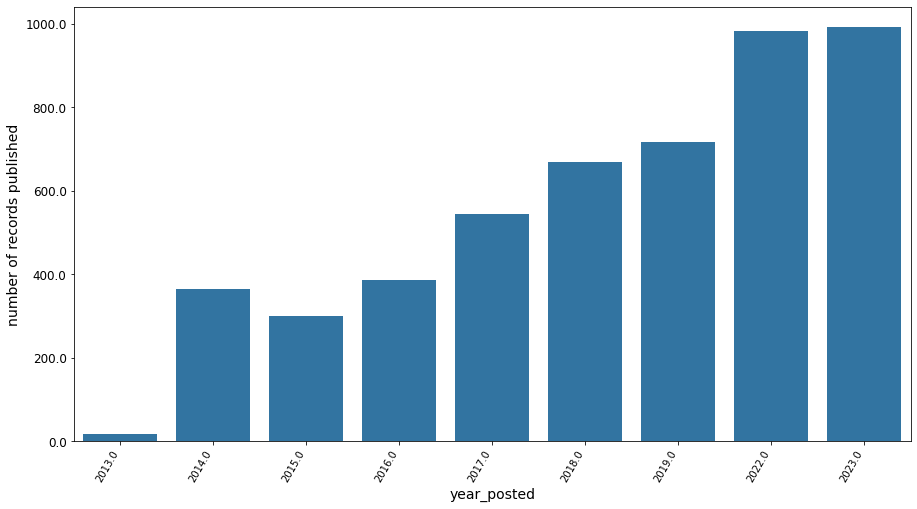

In [60]:
#Use the posted date because the firstOnline date may not align with the actual Figshare record. 
#The posted date as this is the date posted on Figshare.

#Add year and month posted columns
df['year_posted'] = pd.DatetimeIndex(df['posted']).year
df['month_posted'] = pd.DatetimeIndex(df['posted']).month

#Another way to do it...Split the year out and add it as a column
#year = df_full["firstOnline"].str.split("-", n = 1, expand = True)
#df_full['year'] = year[0]

#Group by year
datechart = df.groupby(['year_posted']).count().reset_index()

#Chart it all out
#sns.color_palette("husl", 8)
plt.rcParams["figure.figsize"] = (15,8)
ax = sns.barplot(data=datechart, x="year_posted", y="item_id", palette=["C0"])
#ax.set(xlabel='year', ylabel='number of records published')
ax.set_ylabel("number of records published", fontsize = 14)
ax.set_xlabel("year_posted", fontsize = 14)
ax.set_xticklabels(datechart['year_posted'], fontsize = 10, rotation=60, ha="right")
ax.set_yticklabels(ax.get_yticks(), fontsize = 12)

## Views per time
Really should use first online date. see this example: https://figshare.shef.ac.uk/articles/dataset/CoVid_Plots_and_Analysis/12328226 If things are versioned then the posted date and views no longer align it seems

In [61]:
dfviews = df.copy() 

In [62]:
#There is at least one missing firstOnline date so replace that with the posted date just in this dataframe
dfviews['firstOnline'].fillna(dfviews['posted'], inplace=True)

In [63]:
#----!!!!!!!! Adjust the values for your data collection date

current_month = 6
current_year = 2023

def calc(row):
    if row['month_posted'] != current_month and row['year_posted'] == current_year: #number of months from current year
        return (current_month-row['month_posted'])
    elif row['month_posted'] == current_month and row['year_posted'] == current_year: #If published in current month and year
        return 0.75 #data was collected on Oct 26 so if item posted this september just assign it 0.75
    else:
        return ((current_year-(row['year_posted']+1))*12)+(12-row['month_posted'])+current_month #add 1 to the posted year first then subtract to get full years, then add the months from posted year, then months for current year

    
dfviews['months_since_posted'] = dfviews.apply(calc, axis=1)


dfviews['views_per_month'] = dfviews['views']/dfviews['months_since_posted']
dfviews['log_views_per_month'] = np.log(dfviews['views_per_month'])
#df['downloads_per_month'] = df['downloads']/df['months_since_posted']

#Save to CSV
#dfviews.to_csv('DeleteExamineViews.csv', index = False, header=True)

c:\users\andre.desktop-dfg3gu2\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log Views per Month')

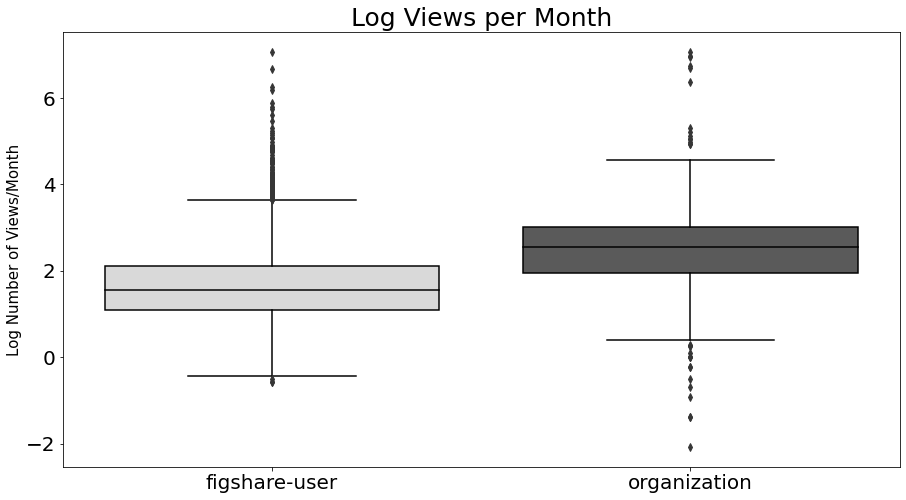

In [64]:
#Create a chart


ax = sns.boxplot(data=dfviews, x='origin', y='log_views_per_month', palette=sns.color_palette(colors, 2),**PROPS)#, palette="Blues_d")
ax.set(xlabel=None)
xticks = plt.xticks()
#wrap_labels(ax,14)
ax.set_ylabel('Log Number of Views/Month', fontsize=y_axis_label_font)
ax.tick_params(axis='x', which='major', labelsize=x_tick_size)
ax.tick_params(axis='y', which='major', labelsize=y_tick_size)
ax.set_title('Log Views per Month', fontsize=chart_title_font)
#ax.text(0.5, 0.8,'*', ha='center', fontsize = startfont, transform=ax6.transAxes)


#Save Figure
#plt.savefig('viewsmonth-color-pres.jpg', dpi=180, format="jpg")

### Examine Files

In [65]:
filesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13425 entries, 0 to 13424
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            13425 non-null  int64 
 1   name          13425 non-null  object
 2   size          13425 non-null  int64 
 3   is_link_only  13425 non-null  bool  
 4   download_url  13425 non-null  object
 5   supplied_md5  13425 non-null  object
 6   computed_md5  13425 non-null  object
 7   item_id       13425 non-null  int64 
dtypes: bool(1), int64(3), object(4)
memory usage: 747.4+ KB


In [66]:
linked_record = filesdf.groupby(by=['is_link_only']).count().reset_index()
linked_record

is_link_only     id   name   size  download_url  supplied_md5  \
0         False  13337  13337  13337         13337         13337   
1          True     88     88     88            88            88   

   computed_md5  item_id  
0         13337    13337  
1            88       88

In [67]:
file_item_list = filesdf['item_id'].unique()
print(len(file_item_list),'items have at least one file or a link to a file')
print(5000-len(file_item_list), 'items have no file or link to file')

4886 items have at least one file or a link to a file
114 items have no file or link to file


In [68]:
pub_date = df[['item_id','year_posted']]
pub_date['file_status'] = np.where(pub_date['item_id'].isin(file_item_list), 'Has files or link', 'No files or link')


<ipython-input-68-bab8f8bf7db1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub_date['file_status'] = np.where(pub_date['item_id'].isin(file_item_list), 'Has files or link', 'No files or link')


In [69]:
pub_date.head()

item_id  year_posted        file_status
0  20231718       2023.0  Has files or link
1  20231682       2023.0  Has files or link
2  22129361       2023.0  Has files or link
3  23280182       2023.0  Has files or link
4  23279966       2023.0  Has files or link

In [70]:
pub_chart = pub_date.groupby(['year_posted','file_status']).count().reset_index()
pub_chart['percent'] = pub_chart['item_id'] / pub_chart.groupby('year_posted')['item_id'].transform('sum')
pub_chart_with_file = pub_chart[pub_chart['file_status'] == 'Has files or link']
pub_chart_with_file.head()

year_posted        file_status  item_id   percent
0       2013.0  Has files or link       17  1.000000
1       2014.0  Has files or link      364  1.000000
2       2015.0  Has files or link      301  1.000000
3       2016.0  Has files or link      387  1.000000
4       2017.0  Has files or link      542  0.994495

[Text(0, 0, '2013.0'),
 Text(1, 0, '2014.0'),
 Text(2, 0, '2015.0'),
 Text(3, 0, '2016.0'),
 Text(4, 0, '2017.0'),
 Text(5, 0, '2018.0'),
 Text(6, 0, '2019.0'),
 Text(7, 0, '2022.0'),
 Text(8, 0, '2023.0')]

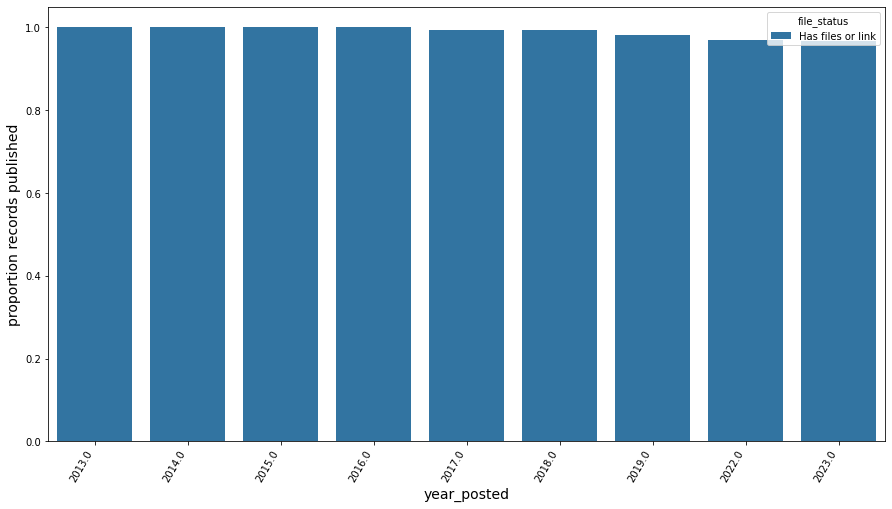

In [196]:

#Chart it all out
#sns.color_palette("husl", 8)
plt.rcParams["figure.figsize"] = (15,8)
ax = sns.barplot(data=pub_chart_with_file, x="year_posted", y="percent", hue="file_status", palette=["C0"])
#ax.set(xlabel='year', ylabel='number of records published')
ax.set_ylabel("proportion records published", fontsize = 14)
ax.set_xlabel("year_posted", fontsize = 14)
ax.set_xticklabels(datechart['year_posted'], fontsize = 10, rotation=60, ha="right")
#ax.set_yticklabels(ax.get_yticks(), fontsize = 12)

### Look for README


In [72]:

readme1 = filesdf[filesdf['name'].str.contains("README") | filesdf['name'].str.contains("readme")]

prop_readmes = (len(readme1['item_id'].unique()))/len(filesdf)

print(len(readme1), "files are named README or readme")
print('Representing',len(readme1['item_id'].unique()),'records')

175 files are named README or readme
Representing 152 records


### File extensions

In [73]:
#
filesdf['ext_pullout'] = filesdf['name'].str[-6:] #create col with last six digits
temp_df = filesdf['ext_pullout'].str.split(".", n = 1, expand = True)  # Split string once on the period, expand to new columns in new df  
filesdf['extension'] = temp_df[1] #Then add the extension column from the temp df to the current df

extensions = filesdf['extension'].value_counts().to_frame().reset_index().rename(
           columns={'index': 'file_type', 'extension': 'count'})

extensions['proportion'] = extensions['count']/len(filesdf) #Add a proportion col

In [74]:
extensions.head(20)

file_type  count  proportion
0          m   2012    0.149870
1        zip   1944    0.144804
2          R   1103    0.082160
3       xlsx    827    0.061601
4         py    755    0.056238
5        txt    584    0.043501
6      sigml    328    0.024432
7        csv    307    0.022868
8      ipynb    256    0.019069
9         gz    235    0.017505
10       pdf    215    0.016015
11       mat    186    0.013855
12       Rmd    177    0.013184
13       jpg    140    0.010428
14       rar    131    0.009758
15       tsv    129    0.009609
16        sh    122    0.009088
17      html    113    0.008417
18         r    112    0.008343
19       asv     95    0.007076

### References

In [91]:
test = df['references'][0:10]
test

0                                      []
1                                      []
2    [https://doi.org/10.1364/AO..000000]
3                                      []
4                                      []
5                                      []
6                                      []
7                                      []
8                                      []
9                                      []
Name: references, dtype: object

In [188]:
#Look in the references field - this is number of ITEMS with at least one reference in references
count = 0
for r in df['references']:
    if len(r) == 0:
        count += 1
zero_refs = count
print(len(df) - count, "items have at least one reference")

1703 items have at least one reference


### Github References

In [129]:
count = 0
#Look in the references field - this is number of ITEMS with at least one github reference in references
for r in df['references']:
    if any('github' in sub for sub in r):
        count += 1

print(count, "items have at least one github reference")

833 items have at least one github reference


In [178]:
#This way creates a dataframe of the acutal items referencing github
gitref = df[['item_id','references']]
gitref['ref_string'] = [','.join(map(str, l)) for l in gitref['references']]
gitref_yes = gitref[gitref['ref_string'].str.contains(".github")]
len(gitref_yes)

<ipython-input-178-4b6964416d01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gitref['ref_string'] = [','.join(map(str, l)) for l in gitref['references']]


833

In [130]:
#Look in the description field
gitdesc = df[df['description'].str.contains(".github")]


print(len(gitdesc), "items have at least one github reference")
print('Representing',len(gitdesc['item_id'].unique()),'records')

192 items have at least one github reference
Representing 192 records


In [179]:
#Okay, how many records wtih github in description don't have a reference?
ref_id_list = gitref_yes['item_id'].tolist()
desc_id_list = gitdesc['item_id'].tolist()
#This next line coverts to sets and returns a list of unique entries from the first list.
desc_uniques = list(set(desc_id_list) - set(ref_id_list))
len(desc_uniques)

93

#### So a total of  926 (833+93) items have at least one .github link in either the description or references

In [192]:
print(1-(zero_refs/len(df)),'proportion of items with at least one reference')
print(len(gitref_yes)/(len(df)-zero_refs),'proportion of references that contain github')
print((len(desc_uniques)+len(gitref_yes))/len(df),'proportion of items with at least one github reference')

0.3425181013676589 proportion of items with at least one reference
0.4891368173810922 proportion of references that contain github
0.18624296057924378 proportion of items with at least one github reference


In [180]:
len(df)

4972

### What are the common domains in references?

In [46]:
with open("full_records-2023-06-02.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    item_metadata = json.load(read_file)

In [181]:
#Look at the institutions represented
url = []
for s in item_metadata:
    if len(s['references']) > 0:
        for r in s['references']:
            url.append(r[8:14])

unique_domains = Counter(url)
len(unique_domains)

372

In [183]:
len(url)

2213

In [182]:
#I think this is off by 6 because there are 6 github urls that don't perfeclty align with the https://github.com url
refs = pd.DataFrame.from_dict(unique_domains, orient='index').reset_index().rename(
           columns={'index': 'url', 0: 'count'})
refs = refs.sort_values(by='count', ascending=False)
refs.head(10)

url  count
1    github    827
0    doi.or    517
46   x.doi.     68
10   arxiv.     34
5    gitlab     30
345  /RG.2.     20
215  dx.doi     14
111  rxiv.o     14
255  theses     12
156  uelcyc     12

### References to a paper

In [19]:
#Print the non null refs to a paper for organization records (at the time of this data collection figshare.com records could only access those fields through the API)
#coul also use 'related_materials' column and get refs with is_linkout=1
print(df[df['origin']=='organization']['resource_doi'].count())

print(df[df['origin']=='organization']['resource_doi'].count()/len(df[df['origin']=='organization']), 'proportion items that link to a paper')

376
0.4973544973544973 proportion items that link to a paper


In [29]:
count = 0
#Look in the references field - this is number of ITEMS with at least one github reference in references
for r in df['references']:
    if any('github' in sub for sub in r):
        count += 1

print(count, "items have at least one doi reference")

0 items have at least one doi reference


In [36]:
count = 0
#Look in the references field - this is number of ITEMS with at least one github reference in references
for r in df['references']:
    if any('github' in r):
        count += 1

print(count, "items have at least one doi reference")

TypeError: 'bool' object is not iterable

In [39]:
any('github' in sub for sub in r)

False

In [43]:
#This way creates a dataframe of the acutal items referencing github
pubref = df[['item_id','references']]
#pubref['ref_string'] = [','.join(map(str, l)) for l in pubref['references']]
for l in pubref['references']:
    list_1.append(l.split(','))
#pubref_yes = pubref[pubref['ref_string'].str.contains(".github")]
#len(pubref_yes)
list_1[10:30]

[['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ["['https://github.com/parsa-git/ADAFEST']"],
 ["['https://github.com/parsa-git/CodART']"],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ["['https://doi.org/10.21105/joss.02891'",
  " 'https://learningsimulator.org/'",
  " 'https://doi.org/10.1016/j.beproc.2023.104893']"],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]'],
 ['[]']]

In [45]:
count = 0
for l in list_1:
    if any('github' in sub for sub in r):
        count += 1
print(count)
    

0


In [46]:
l

["['https://www.nature.com/articles/ncomms15393']"]

In [40]:
test2.tolist()

AttributeError: 'str' object has no attribute 'tolist'

In [35]:
type(test2)

str

### Look at licenses

In [185]:
#Look at license list
list_license = df['license'].value_counts()

df_license = list_license.to_frame()
df_license.head()

license
{'value': 1, 'name': 'CC BY 4.0', 'url': 'https...     2965
{'value': 3, 'name': 'MIT', 'url': 'https://ope...     1310
{'value': 6, 'name': 'GPL 3.0+', 'url': 'https:...      206
{'value': 2, 'name': 'CC0', 'url': 'https://cre...      183
{'value': 7, 'name': 'Apache 2.0', 'url': 'http...       86

### A look at tags

In [186]:
tops = tagsdf['name'].value_counts() #this is a series
tops = tops.to_frame()
tops.sort_values(by='name', ascending=False)

tops.head(20)

name
Bioinformatics                                 293
Computer Software                              254
Computational  Biology                         165
Ecology                                        149
Artificial Intelligence and Image Processing   142
Neuroscience                                   131
Programming Languages                          129
Evolutionary Biology                           127
Applied Computer Science                       114
Computer Engineering                           101
Software Engineering                            98
Statistics                                      98
image analysis                                  90
image processing                                89
computer vision                                 86
Bioinformatics Software                         79
R                                               77
python                                          75
Environmental Science                           65
machine learning                                55

### Look at categories

In [187]:
tops = categoriesdf['title'].value_counts() #this is a series
tops = tops.to_frame()
tops.sort_values(by='title', ascending=False)

tops.head(20)

title
Bioinformatics and computational biology not el...    509
Software engineering not elsewhere classified         371
Ecology not elsewhere classified                      204
Neurosciences not elsewhere classified                148
Artificial intelligence not elsewhere classified      148
Programming languages                                 140
Evolutionary biology not elsewhere classified         132
Applied computing not elsewhere classified            123
Digital processor architectures                       114
Other information and computing sciences not el...    109
Animal physiology - biophysics                        108
Statistics not elsewhere classified                    91
Applications in life sciences                          83
Human biophysics                                       78
Bioinformatic methods development                      77
Other environmental sciences not elsewhere clas...     74
Biological Sciences not elsewhere classified           71
Community ecology (excl. invasive species ecology)     70
Genomics                                               61
Genetics not elsewhere classified                      58

# OLD

In [74]:
#Are any missing stats?
missing_stats = df[df['views'].isna()]
missing_stats.head()

Empty DataFrame
Columns: [custom_fields, figshare_url, description, version, status, size, created_date, modified_date, is_public, is_confidential, is_metadata_record, confidential_reason, metadata_reason, license, references, has_linked_file, citation, is_embargoed, embargo_date, embargo_type, embargo_title, embargo_reason, embargo_options, item_id, title, doi, handle, url, published_date, thumb, defined_type, defined_type_name, group_id, url_private_api, url_public_api, url_private_html, url_public_html, resource_title, resource_doi, views, posted, firstOnline, publisherPublication, publisherAcceptance, origin, edited_group_id, year_posted, month_posted]
Index: []

[0 rows x 48 columns]